Elements for a CO WD type Ia supernova

H1 $\to$ 1, 1, 1.00727 (accreted from companion) \
H2 $\to$ 2, 1, 2.0140  (accreted from companion) \
He3 $\to$ 3, 2, 3.01603 (accreted from companion) \
He4 $\to$ 4, 2, 4.00260 (accreted from companion) \
C12 $\to$ 12, 6, 12. (CNO ) \
N14 $\to$  14, 7, 14.007 (CNO) \
O16 $\to$ 16, 8, 15.994 (CNO) \
Ne20 $\to$ 20, 10, 20.1797 (alpha network) \
Mg24 $\to$ 24, 12, 24.3050 (alpha network) \
Si28 $\to$ 28, 14, 27.976 (alpha network) \
S32 $\to$ 32, 16, 31.972 (alpha network) \
Ar36 $\to$ 36, 18, 35.967 (alpha network) \
Ca40 $\to$ 40, 20, 39.962 (alpha network) \
Ti44 $\to$ 44, 22, 43.9596 (alpha network) \
Cr48 $\to$ 48, 24, 47.9540 (alpha network) \
Fe52 $\to$ 52, 26, 51.9481 (alpha network) \
Fe54 $\to$ 54, 26, 53.939 (electron capture) \
Ni56 $\to$ 56, 28, 55.940 (alpha network) \
Co56 $\to$ 56, 27, 55.9398393 (decay of 56Ni) \
Fe56 $\to$ 56, 26, 55.9349 (decay of 56Co) \
Fe57 $\to$ 57, 26, 56.9353 (decay of 58Fe) \
Fe58 $\to$ 58, 26, 57.9332 (neutron capture) \
Ni58 $\to$ 58, 28, 57.9353429 (neutron capture) 

In [36]:
import abc
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'retina'

In [37]:
# Global constants
km_cm = 1e5            # km to cm
Msun = 1.9884e33       # g

In [38]:
class elements:
    
    def __init__(self, A, Z, weight, repr):
        
        '''
        A: maass number
        Z: atomin number
        weight: atomic weight (in amu)
        
        '''
        
        self.A = A
        self.Z = Z
        self.weight = weight
        self.repr = repr
        
    def __repr__(self):
        
        '''
        representation object
        
        '''
        
        return '%s: A=%d, Z=%d, weight=%.3f' %(self.repr, self.A,
                                              self.Z, self.weight)
    

class Layers:
    
    def __init__(self, abundances):
        
        '''
        abundances: Abundances of the layers. Any set of abundance for a layer will be normalized.
        
        '''
        
        self.normalization = sum(abundances.values())
        self.abundances = {key:abundances[key]/self.normalization 
                          for key in abundances}
        
    def __repr__(self):
        
        s = 'Layer:\n'
        return s + '\n'.join(['\t%s abundance = %.3e' % (key, self.abundances[key])
                             for key in self.abundances])
    
    
class exp_density_profile:
    
    '''
    An exponential density profile.
    
    '''
    
    def __init__(self, ke, mass):
        
        self.ke = ke         # erg
        self.mass = mass     # msun
        self.ve = np.sqrt(ke / (6.0 * mass * Msun)) / km_cm
        
    
    def __call__(self, v):
        
        z = v / self.ve
        
        return 1 - 0.5 * (np.exp(-z) * (2 + 2*z + z**2))
    
    

    
class Stratified_Atmosphere:
    
   

    def __init__(self, layers, masses, profile, nzones=100, v_outer=4e4,
                texp=86400.):
        
        # state 
        self.layers = layers
        self.profile = profile
        self.masses = masses
        
        
        # parameters 
        
        self._nzones = nzones
        self._v_outer = v_outer
        self._texp = texp
        
    
    def velocity(self, kind='average'):
        
        """
        Zone radial velocities (km /s).
    
        """
        
        if kind == 'outer':
            
            return (self._v_outer / self._nzones) * np.arange(1, self._nzones + 1)
        
        else:
            boundary_vels = np.concatenate((np.asarray([0.]),
                                          self.velocity(kind='outer')))
            
            if kind == 'average':
                
                return (boundary_vels[:-1] + boundary_vels[1:]) / 2.
            
            elif kind == 'inner':
                
                return boundary_vels[:-1]
            
            else:
                
                return ValueError('kind must be one of outer, inner, average')
            
    
    @property 
    def interior_mass(self):
        
        vo = self.velocity(kind='outer')
        return self.profile(vo) * sum(self.masses)
    
    @property
    def shell_mass(self):
        
        im = self.interior_mass
        return np.concatenate(([im[0]], im[1:] - im[:-1]))
    
    
    def layer_mass(self, layerind, i):
        
        return self.shell_mass[i]  * self.frac[i, layerind]
    
    
    def total_ejecta_mass(self):
        
        return self.interior_mass[-1]
    
            
    
    def Atmos(self):
        
        # grid 
        
        self.vgrid_outer = self.velocity(kind='outer')
        self.vgrid_inner = self.velocity(kind='inner')
        self.vgrid_avg = self.velocity(kind='average')
        
        # enumerate unique elements in the atmosphere
        
        spec = []
        for layer in self.layers:
            spec += list(layer.abundances.keys())
            
        self._spec = sorted(set(spec), key = lambda x: x.weight)[::-1]
        
        # initialize composition array
        
        self.comp = np.zeros((self._nzones, self.nspec))
        self.frac = np.zeros((self._nzones, len(self.layers)))
        
        radii = [0]
        for j in range(len(self.layers)):
            radii.append(radii[j] + self.masses[j])
            
        self.radii = np.asarray(radii[1:])
        self.edge_shells = list(map(self.interior_mass.searchsorted, self.radii))

        
        for i in range(self._nzones):   # nzones = 100
            sm = self.shell_mass[i]
            isedge = np.asarray(self.edge_shells[:-1]) == i
            nedge = isedge[isedge].size
            
            if nedge == 0:
                bounds = [0] + self.edge_shells
                for j in range(len(self.layers)):
                    if bounds[j] <= i <= bounds[j+1]:
                        self.frac[i, j] = 1.
                        self.comp[i] = self._abun(self.frac[i]) 
                        
            else:
                
                ending, kmax = np.argwhere(isedge)[[0, -1], 0]
                starting = kmax + 1
                
                prev_mass = sum([self.layer_mass(ending, l)
                                for l in range(0, i)])
                
                remaining_mass = self.masses[ending] - prev_mass
                
                self.frac[i, ending] = remaining_mass / sm
                
                for k in range(ending+1, starting)[::-1]:
                    self.frac[i, k] = self.masses[k] / sm
                self.frac[i, starting] = 1 - sum(self.frac[i, ending:starting])
                self.comp[i] = self._abun(self.frac[i])
                
        
    def _indexof(self, element):
        
        return self.spec.index(element)
 
    @property
    def spec(self):
        return self._spec
        
    @property
    def nspec(self):
        return len(self.spec)
    
    def _abun(self, frac):
        
        result = np.zeros(self.nspec)
        for layer, frac in zip(self.layers, frac):
            for elem in layer.abundances:
                result[self._indexof(elem)] += layer.abundances[elem] * frac
        
        return result
    
    
    def plot_ejecta(self):
        
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        
        colors = ['#e63946', '#48cae4', '#006d77', '#9d4edd', '#c44536',
                  '#ff7f51', '#a4ac86', '#90be6d', '#b298dc', '0466c8']
        
        ls = ['-', '--', '-.', ':']
        
        styles = [{'color':c, 'ls':linestyle} for c in colors for linestyle in ls]
        
        ele = [elem.repr for elem in self.spec]
        v_avg = self.velocity(kind='average')
        
        
        

In [39]:
# A supernova atmosphere

# Unburned 

C12 = elements(12, 6, 12., 'C12')
O16 = elements(16, 8, 15.994, 'O16')
Ne20 = elements( 20, 10, 20.1797, 'Ne20')

# IME

Mg24 = elements(24, 12, 24.3050, 'Mg24')
Si28 = elements(28, 14, 27.976, 'Si28')
S32 = elements(32, 16, 31.972, 'S32')
Ca40 = elements(40, 20, 39.962, 'Ca40')

# IGE 

Fe54 = elements(54, 26, 53.939, 'Fe54')
Ni58 = elements(58, 28, 57.9353429, 'Ni58')

# Ni56

Ni56 = elements(56, 28, 55.940, 'Ni56')

In [40]:
# Ejecta Layers

co = Layers({C12: 0.45, O16: 0.5, Ne20: 0.05})

ime = Layers({Mg24: 0.1, Si28: 0.50, S32: 0.3, Ca40: 0.10})

ige = Layers({Fe54: 0.5, Ni58: 0.5})

ni = Layers({Ni56: 1.0})

In [41]:
profile = exp_density_profile(1e51, 1.2)

In [42]:
layers = [ige, ni, ime, co]

In [43]:
# 1.3 Msolar white dwarf 
# 0.2 solar mass of ige, 0.6 solar mass of 56Ni, 0.3 solar mass of ime, 0.2 solar mass of CO
layermasses = [0.2, 0.6, 0.3, 0.2]

In [44]:
stra = Stratified_Atmosphere(layers, layermasses, profile)

In [45]:
stra.Atmos()

[Ni58: A=58, Z=28, weight=57.935, Ni56: A=56, Z=28, weight=55.940, Fe54: A=54, Z=26, weight=53.939, Ca40: A=40, Z=20, weight=39.962, S32: A=32, Z=16, weight=31.972, Si28: A=28, Z=14, weight=27.976, Mg24: A=24, Z=12, weight=24.305, Ne20: A=20, Z=10, weight=20.180, O16: A=16, Z=8, weight=15.994, C12: A=12, Z=6, weight=12.000]
['Ni58', 'Ni56', 'Fe54', 'Ca40', 'S32', 'Si28', 'Mg24', 'Ne20', 'O16', 'C12']


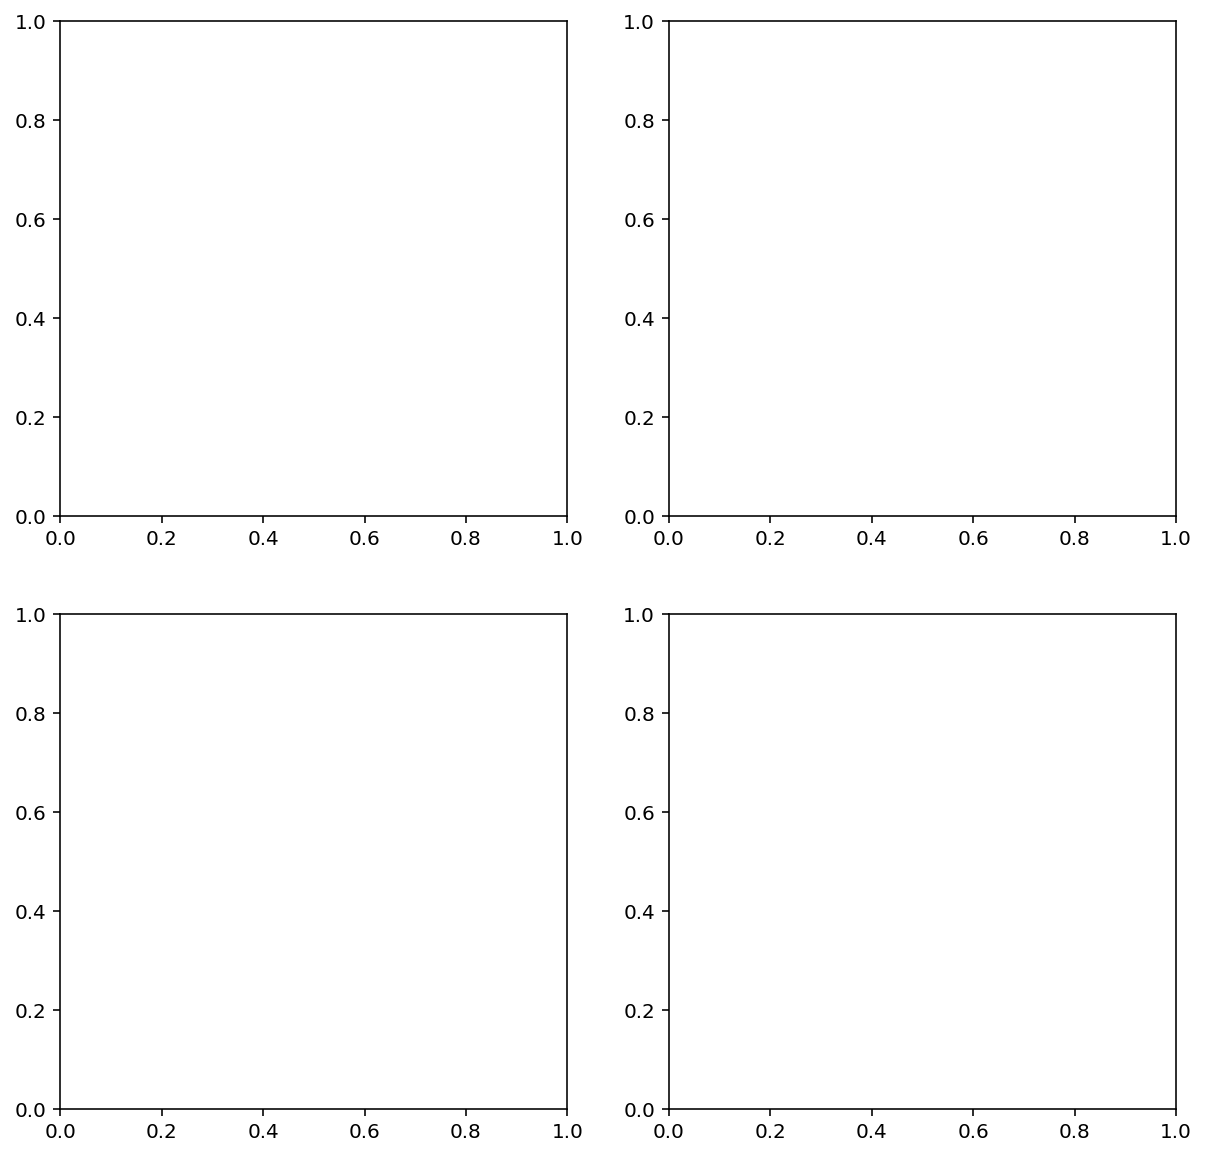

In [46]:
stra.plot_ejecta()